In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip
/kaggle/input/airbnb/testing_features.csv
/kaggle/input/airbnb/final_prediction.csv
/kaggle/input/airbnb/session_features.csv
/kaggle/input/airbnb/training_features.csv
/kaggle/input/airbnb/labels.csv


# Import Libraries

In [2]:
import collections
import numpy as np
import pandas as pd
import scipy.stats as stats
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from random import choice
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities

In [ ]:
# def remove_rare_values_inplace(df_frame, column_list, threshold):
#     """ Remove rare values to speed up computation.
#     Args:
#         df_frame -- A pandas data frame.
#         column_list -- A list of columns.
#         threshold -- The threshold, below which a value is removed.
#     """
#     insignificant_population = int(np.floor(threshold * len(df_frame)))
#     for cat in column_list:
#         freqs = collections.Counter(df_frame[cat])
#         other = [i for i in freqs if freqs[i] < insignificant_population]
#         for i in other:
#             df_frame[cat].replace(i, 'other', inplace=True)

# Feature Extraction

In [ ]:
# '''
# Extracting freatures from the session data.
# The data set can be found here:
# www.kaggle.com/c/airbnb-recruiting-new-user-bookings/download/sessions.csv.zip
# '''

# INDEX_COLUMN = 'user_id'
# SECS_ELAPSED_NUMERICAL = 'secs_elapsed'
# CATEGORICAL_FEATURES = ['action', 'action_type', 'action_detail', 'device_type']
# SESSSIONS_CSV_FILE = '/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip'
# OUTPUT_TO_CSV_FILE = 'session_features.csv'  # Results will be saved here.

# # A parameter to speed-up computation. Categorical values that appear
# # less than the threshold will be removed.
# VALUE_THRESHOLD = 0.005


# def extract_frequency_counts(pd_frame, column_list):
#     """ Extract frequency counts from pd_frame.
#     For each index (that correspond to a user) this method will count the
#     number of times that C == Ci, where C is a column in column_list, and Ci
#     is a unique value of that column. The arg olumn_list is assumed
#     to contain categorical columns.
#     Args:
#         df_frame -- A pandas data frame.
#         column_list -- A list of columns.
#     Returns:
#         A pandas DataFrame, containing frequency counts.
#     """
#     df_extracted_sessions = []
#     for col in column_list:
#         for val in set(pd_frame[col]):
#             print('Extracting frequency counts for (%s == %s)' % (col, val))
#             tmp_df = pd_frame.groupby(pd_frame.index).apply(
#                 lambda group, x=col, y=val: np.sum(group[x] == y))
#             tmp_df.name = '%s=%s' % (col, val)
#             df_extracted_sessions.append(tmp_df)
#     frequency_counts = pd.concat(df_extracted_sessions, axis=1)
#     return frequency_counts


# def extract_distribution_stats(pd_frame, numerical_col):
#     """ Extract simple distribution statistics from a numerical column.
#     Args:
#         df_frame -- A pandas data frame.
#         numerical_col -- A column in pd_frame that contains numerical values.
#     Returns:
#         A pandas DataFrame, containing simple satistics for col_name.
#     """
#     tmp_df = pd_frame[numerical_col].groupby(pd_frame.index).aggregate(
#         [np.mean, np.std, np.median, stats.skew])
#     tmp_df.columns = ['%s_%s'% (numerical_col, i) for i in tmp_df.columns]
#     return tmp_df


# """
# Extract frequency counts from categorical columns and simple distribution
# statistics from numerical ones.
# """
# # Load basic training and testing data, from CSV file.
# sessions = pd.read_csv(SESSSIONS_CSV_FILE)
# sessions.set_index(INDEX_COLUMN, inplace=True)
# sessions.fillna(-1, inplace=True)
# # Extract features from sessions.
# remove_rare_values_inplace(sessions, CATEGORICAL_FEATURES, VALUE_THRESHOLD)
# frequency_counts = extract_frequency_counts(sessions, CATEGORICAL_FEATURES)
# simple_stats = extract_distribution_stats(sessions, SECS_ELAPSED_NUMERICAL)
# # Save new data.
# session_data = pd.concat((frequency_counts, simple_stats), axis=1)
# session_data.fillna(-1, inplace=True)
# session_data.to_csv(OUTPUT_TO_CSV_FILE)

# Data Preparation

## Data Exploration

In [3]:
TRAIN_DATA_BASIC = '/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip'
TEST_DATA_BASIC = '/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip'

training = pd.read_csv(TRAIN_DATA_BASIC, index_col=0)
testing = pd.read_csv(TEST_DATA_BASIC, index_col=0)

In [4]:
print("We have", training.shape[0], "users in the training set and", 
      testing.shape[0], "in the test set.")
print("In total we have", training.shape[0] + testing.shape[0], "users.")

We have 213451 users in the training set and 62096 in the test set.
In total we have 275547 users.


In [5]:
# Merge train and test users
users = pd.concat((training, testing), axis=0, ignore_index=True)

users.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,facebook,20090319043255
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,20090609231247
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,basic,20091208061105


### Missing Data

In [6]:
users.gender.replace('-unknown-', np.nan, inplace=True)

In [7]:
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan[users_nan > 0].drop('country_destination')

age                        42.412365
date_first_booking         67.733998
first_affiliate_tracked     2.208335
gender                     46.990169
dtype: float64

In [8]:
print("Just for the sake of curiosity; we have", 
      int((training.date_first_booking.isnull().sum() / training.shape[0]) * 100), 
      "% of missing values at date_first_booking in the training data")

Just for the sake of curiosity; we have 58 % of missing values at date_first_booking in the training data


In [9]:
users.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [10]:
print(sum(users.age > 122))
print(sum(users.age < 18))

830
188


In [11]:
users[users.age > 122]['age'].describe()

count     830.000000
mean     2002.620482
std        94.201344
min       132.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

In [12]:
users[users.age < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

In [14]:
users.loc[users.age > 95, 'age'] = np.nan
users.loc[users.age < 13, 'age'] = np.nan

Visualization

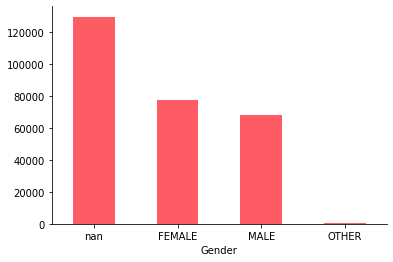

In [20]:
users.gender.value_counts(dropna=False).plot(kind='bar', color='#FD5C64', rot=0)
plt.xlabel('Gender')
sns.despine()
plt.savefig('gender.png')

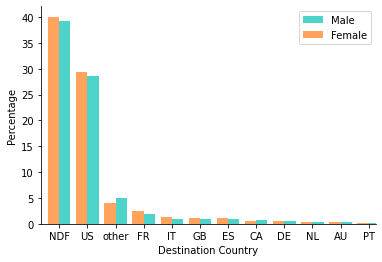

<Figure size 432x288 with 0 Axes>

In [22]:
women = sum(users['gender'] == 'FEMALE')
men = sum(users['gender'] == 'MALE')

female_destinations = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()
plt.savefig('country_by_gender.png')

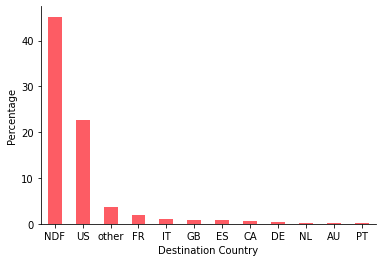

In [24]:
destination_percentage = users.country_destination.value_counts() / users.shape[0] * 100
destination_percentage.plot(kind='bar',color='#FD5C64', rot=0)
# Using seaborn can also be plotted
# sns.countplot(x="country_destination", data=users, order=list(users.country_destination.value_counts().keys()))
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()
plt.savefig('country_percentile.png')

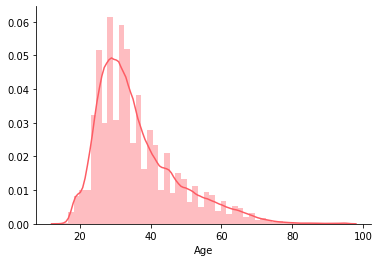

In [25]:
sns.distplot(users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()
plt.savefig('age.png')

In [ ]:
age = 45

younger = sum(users.loc[users['age'] < age, 'country_destination'].value_counts())
older = sum(users.loc[users['age'] > age, 'country_destination'].value_counts())

younger_destinations = users.loc[users['age'] < age, 'country_destination'].value_counts() / younger * 100
older_destinations = users.loc[users['age'] > age, 'country_destination'].value_counts() / older * 100

younger_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Youngers', rot=0)
older_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='Olders', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

In [ ]:
print((sum(users.language == 'en') / users.shape[0])*100)

In [ ]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
users.date_account_created.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

In [ ]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['date_first_active'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')

In [ ]:
users.date_first_active.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

In [ ]:
users_2013 = users[users['date_first_active'] > pd.to_datetime(20130101, format='%Y%m%d')]
users_2013 = users_2013[users_2013['date_first_active'] < pd.to_datetime(20140101, format='%Y%m%d')]
users_2013.date_first_active.value_counts().plot(kind='line', linewidth=2, color='#FD5C64')
plt.show()

In [ ]:
weekdays = []
for date in users.date_account_created:
    weekdays.append(date.weekday())
weekdays = pd.Series(weekdays)

In [ ]:
sns.barplot(x = weekdays.value_counts().index, y=weekdays.value_counts().values, order=range(0,7))
plt.xlabel('Week Day')
sns.despine()

In [ ]:
date = pd.to_datetime(20140101, format='%Y%m%d')

before = sum(users.loc[users['date_first_active'] < date, 'country_destination'].value_counts())
after = sum(users.loc[users['date_first_active'] > date, 'country_destination'].value_counts())
before_destinations = users.loc[users['date_first_active'] < date, 
                                'country_destination'].value_counts() / before * 100
after_destinations = users.loc[users['date_first_active'] > date, 
                               'country_destination'].value_counts() / after * 100
before_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Before 2014', rot=0)
after_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='After 2014', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

## Process Data

In [ ]:
# '''
# Preparing the data for the classifiers.
# '''

LABEL = 'country_destination'
CATEGORICAL_FEATURES = ['affiliate_channel', 'affiliate_provider',
                        'first_affiliate_tracked', 'first_browser',
                        'first_device_type', 'gender', 'language', 'signup_app',
                        'signup_method', 'signup_flow']

DATE_FORMAT = '%Y-%m-%d'                # Expected format for date.
ACCOUNT_DATE = 'date_account_created'   # Date column that will be exploited.
ACCOUNT_DATE_YEAR = '%s_%s' % (ACCOUNT_DATE, 'year')
ACCOUNT_DATE_MONTH = '%s_%s' % (ACCOUNT_DATE, 'month')
UNUSED_DATE_COLUMNS = ['timestamp_first_active', 'date_first_booking']

# TRAIN_DATA_BASIC = '/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip'
# TEST_DATA_BASIC = '/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip'
SESSION_DATA = '/kaggle/input/airbnb/session_features.csv'
TRAINING_FINAL_CSV_FILE = '/kaggle/input/airbnb/training_features.csv'
TESTING_FINAL_CSV_FILE = '/kaggle/input/airbnb/testing_features.csv'
LABELS_FINAL_CSV_FILE = '/kaggle/input/airbnb/labels.csv'

# # A parameter to speed-up computation. Categorical values that appear
# # less than the threshold will be removed.
# VALUE_THRESHOLD = 0.001


# def _parse_date(date_str, format_str):
#     """ Extract features from the data_account_creted column.
#     Warning: There is strong dependency between this method and the method
#     replace_dates_inplace.
#     Args:
#         date_str -- A string containing a date value.
#         str_format -- The format of the string date.
#     Returns:
#         A list of 4 values containing the extracted [year, month, day, weekend].
#     """
#     time_dt = dt.datetime.strptime(date_str, format_str)
#     return [time_dt.year, time_dt.month, time_dt.day, time_dt.weekday()]


# def extract_dates_inplace(features, date_column):
#     """ Extract from the date-columns, year, month, and other numericals.
#     Warning: There is strong dependency between this method and _parse_date.
#     """
#     extracted_vals = np.vstack(features[date_column].apply(
#         (lambda x: _parse_date(x, DATE_FORMAT))))
#     for i, period in enumerate(['year', 'month', 'day', 'weekday']):
#         features['%s_%s' % (date_column, period)] = extracted_vals[:, i]
#     features.drop(date_column, inplace=True, axis=1)


def apply_one_hot_encoding(pd_frame, column_list):
    """ Apply One-Hot-Encoding to pd_frame's categorical columns.
    Args:
        df_frame -- A pandas data frame.
        column_list -- A list of categorical columns, in df_frame.
    Returns:
        A pandas dataframe where the colums in column_list have been replaced
            by one-hot-encoded-columns.
    """
    new_column_list = []
    for col in column_list:
        tmp = pd.get_dummies(pd_frame[col], prefix=col)
        new_column_list.append(tmp)
    new_pd_frame = pd.concat(new_column_list+[pd_frame], axis=1)
    new_pd_frame.drop(column_list, inplace=True, axis=1)
    return new_pd_frame


# def get_basic_train_test_data():
#     """ Load the basic data in a pandas dataframe, and pre-process them. """
#     training = pd.read_csv(TRAIN_DATA_BASIC, index_col=0)
#     testing = pd.read_csv(TEST_DATA_BASIC, index_col=0)
#     labels = training[LABEL].copy()
#     training.drop(LABEL, inplace=True, axis=1)
#     features = pd.concat((training, testing), axis=0)
#     features.fillna(-1, inplace=True)

#     # Process all features by removing rare values, appling one-hot-encoding to
#     # those that are categorical and extracting numericals from ACCOUNT_DATE.

#     remove_rare_values_inplace(features, CATEGORICAL_FEATURES, VALUE_THRESHOLD)
#     features = apply_one_hot_encoding(features, CATEGORICAL_FEATURES)
#     extract_dates_inplace(features, ACCOUNT_DATE)
#     features.drop(UNUSED_DATE_COLUMNS, inplace=True, axis=1)
#     return features, labels, training.index, testing.index


# """ Load basic data, add session data, and prepare them for predition. """
# features, labels, training_ids, testing_ids = get_basic_train_test_data()
# sessions = pd.read_csv(SESSION_DATA, index_col=0)
# features = pd.concat((features, sessions), axis=1)
# features.fillna(-1, inplace=True)
# # Save data training and testing data.
# training = features.ix[training_ids]
# testing = features.ix[testing_ids]

# # Warning: When saving the data, it's important that the header is True,
# # because labels is of type pandas.core.series.Series, while training is of
# # type pandas.core.frame.DataFrame, and they have different default values
# # for the header argument.

# assert set(training.index) == set(labels.index)
# training.to_csv(TRAINING_FINAL_CSV_FILE, header=True)
# testing.to_csv(TESTING_FINAL_CSV_FILE, header=True)
# labels.to_csv(LABELS_FINAL_CSV_FILE, header=True)

# Model Building

In [ ]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = LABEL
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
#         oof_pred = np.zeros((len(train_df), ))
        y_pred = np.zeros((len(test_df), len(set(label))))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            print('--------------------------------------- FOLD %d -----------------------------------------' %fold)
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            
#             conv_x_val = self.convert_x(x_val)
#             oof_pred = model.predict(conv_x_val)
            
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict_proba(x_test) / self.n_splits
            
        return y_pred, model

In [ ]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 3 if self.verbose else 0
        clf = xgb.XGBClassifier(self.get_params())
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=[(val_set['X'], val_set['y'])])
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {
            'max_bin': 63,
            'colsample_bytree': 0.8,                 
            'learning_rate': 0.1,
            'max_depth': 7,
            'subsample': 0.7,
            'objective':'multi:softprob',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000,
            'tree_method':'gpu_hist'}

        return params

In [ ]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        params = self.get_params()
        clf = lgb.LGBMClassifier(max_bin = 100,
                                 device = 'gpu',
                                 num_leaves = 30,
                                 n_estimators = params['n_estimators'],
                                  boosting_type = params['boosting_type'],
                                  objective = params['objective'],
                                  subsample = params['subsample'],
                                  subsample_freq = params['subsample_freq'],
                                  learning_rate = params['learning_rate'],
                                  max_depth = params['max_depth'],
                                  early_stopping_rounds = params['early_stopping_rounds'])
        
        return clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=[(val_set['X'], val_set['y'])])
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {
                    'n_estimators':1000,
                    'boosting_type': 'gbdt',
                    'objective': 'multiclass',
                    'eval_metric': 'logloss',
                    'subsample': 0.7,
                    'subsample_freq': 1,
                    'learning_rate': 0.1,
                    'feature_fraction': 0.9,
                    'max_depth': 7,
                    'early_stopping_rounds': 100
                    }
        return params

In [ ]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        params = self.get_params()
        clf = CatBoostClassifier(learning_rate = params['learning_rate'],
                                  task_type = params['task_type'],
                                  iterations = params['iterations'],
                                  od_type = params['od_type'],
                                  depth = params['depth'],
                                  colsample_bylevel = params['colsample_bylevel'],
                                  l2_leaf_reg = params['l2_leaf_reg'],
                                  random_seed = params['random_seed'],
                                  use_best_model = params['use_best_model'])
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'learning_rate': 0.1,
                   'task_type': "CPU",
                   'iterations':1000,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True
                    }
        return params

In [ ]:
class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scaler = MinMaxScaler()
        train_df[features] = scaler.fit_transform(train_df[features])
        test_df[features] = scaler.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
        
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        #x = tf.keras.layers.Dense(200, activation='relu')(x)
        #x = tf.keras.layers.LayerNormalization()(x)
        #x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(len(set(label)))(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        self.model = model
        return self
    
    def predict_proba(self, x_test):
        return self.model.predict(x_test)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [ ]:
train_df = pd.read_csv(TRAINING_FINAL_CSV_FILE, index_col=0)
test_df = pd.read_csv(TESTING_FINAL_CSV_FILE, index_col=0)
label_df = pd.read_csv(LABELS_FINAL_CSV_FILE, index_col=0)

features = train_df.columns

encoder = LabelEncoder()
encoder.fit(label_df[LABEL])
label = encoder.transform(label_df[LABEL])
train_df['country_destination'] = label
train_df.head()

In [ ]:
# gridParams = {
#     'learning_rate': [0.05, 0.1, 0.2],
#     'num_iterations':[100, 200, 500],
#     'num_leaves': [50, 70, 100],
#     'subsample' : [0.7, 0.75]
# }

# params = {
#                     'n_estimators':5000,
#                     'boosting_type': 'gbdt',
#                     'objective': 'multiclass',
#                     'eval_metric': 'logloss',
#                     'subsample': 0.7,
#                     'subsample_freq': 1,
#                     'learning_rate': 0.1,
#                     'feature_fraction': 0.9,
#                     'max_depth': 7,
#                     'lambda_l1': 1,  
#                     'lambda_l2': 1,
#                     'early_stopping_rounds': 100
# }

# clf = lgb.LGBMClassifier(max_bin = 100,
#                                  num_iterations = 200,
#                                  device = 'gpu',
#                                  gpu_platform_id = 0,
#                                  gpu_device_id = 0,
#                                  num_leaves = 70,
#                                   boosting_type = params['boosting_type'],
#                                   objective = params['objective'],
#                                   eval_metric = params['eval_metric'],
#                                   subsample = params['subsample'],
#                                   subsample_freq = params['subsample_freq'],
#                                   learning_rate = params['learning_rate'],
#                                   feature_fraction = params['feature_fraction'],
#                                   max_depth = params['max_depth'],
#                                   lambda_l1 = params['lambda_l1'],
#                                   lambda_l2 = params['lambda_l2'])

# grid = GridSearchCV(clf, gridParams,
#                     verbose=2,
#                     cv=5,
#                     n_jobs=-1)
# # Run the grid
# grid.fit(train_df[features], train_df[LABEL])

# print(grid.best_params_)
# print(grid.best_score_)

In [ ]:
LGB_WEIGHT = 0.4
LGB_FRESH_WEIGHT = 0.6
XGB_WEIGHT = 0.0
XGB_FRESH_WEIGHT = 0.0
CAT_WEIGHT = 0.0
CAT_FRESH_WEIGHT = 0.0
CNN_WEIGHT = 0.0
CNN_FRESH_WEIGHT = 0.0
FRESH_DATA_YEAR = 2014                   # Year when data is considered fresh.

In [ ]:
if LGB_WEIGHT:
    lgb_model = Lgb_Model(train_df, test_df, features=features, verbose=False)

In [ ]:
if LGB_FRESH_WEIGHT:
    lgb_fresh_model = Lgb_Model(train_df[train_df[ACCOUNT_DATE_YEAR] >= FRESH_DATA_YEAR], test_df, features=features, verbose=True)

In [ ]:
if XGB_WEIGHT:
    xgb_model = Xgb_Model(train_df, test_df, features=features, verbose=False)

In [ ]:
if XGB_FRESH_WEIGHT:
    xgb_fresh_model = Xgb_Model(train_df[train_df[ACCOUNT_DATE_YEAR] >= FRESH_DATA_YEAR], test_df, features=features, verbose=True)

In [ ]:
if CAT_WEIGHT:
    cat_model = Catb_Model(train_df, test_df, features=features, verbose=False)

In [ ]:
if CAT_FRESH_WEIGHT:
    cat_fresh_model = Catb_Model(train_df[train_df[ACCOUNT_DATE_YEAR] >= FRESH_DATA_YEAR], test_df, features=features, verbose=True)

In [ ]:
if CNN_WEIGHT:
    cnn_model = Cnn_Model(train_df, test_df, features=features, verbose=False)

In [ ]:
# label_df['country_destination'].value_counts()

In [ ]:
# predictions

In [ ]:
# predictions[0][np.argsort(predictions[0])[::-1]][4]
# # predictions[0] * 100

# Ensemble

In [ ]:
predictions = np.zeros((len(test_df), len(set(label))))

if LGB_WEIGHT:
    predictions += LGB_WEIGHT * lgb_model.y_pred
if LGB_FRESH_WEIGHT:
    predictions += LGB_FRESH_WEIGHT * lgb_fresh_model.y_pred
if XGB_WEIGHT:
    predictions += XGB_WEIGHT * xgb_model.y_pred
if XGB_FRESH_WEIGHT:
    predictions += XGB_FRESH_WEIGHT * xgb_fresh_model.y_pred
if CAT_WEIGHT:
    predictions += CAT_WEIGHT * cat_model.y_pred
if CAT_FRESH_WEIGHT:
    predictions += CAT_FRESH_WEIGHT * cat_fresh_model.y_pred
if CNN_WEIGHT:
    predictions += CNN_WEIGHT * cnn_model.y_pred
if CNN_FRESH_WEIGHT:
    predictions += CNN_FRESH_WEIGHT * cnn_fresh_model.y_pred

# Training

In [ ]:
# '''
# Predict Users' new booking by combining of RnadomForest and XGB classifiers.
# '''
# DEPTH_XGB, ESTIMATORS_XGB, LEARNING_XGB, SUBSAMPLE_XGB, COLSAMPLE_XGB = (
#     7, 60, 0.2, 0.7, 0.6)                # XGBoost parameters.

# ESTIMATORS_RF, CRITERION_RF, DEPTH_RF, MIN_LEAF_RF, JOBS_RF = (
#     500, 'gini', 20, 8, 30)              # RandomForestClassifier parameters.
# FRESH_DATA_YEAR = 2014                   # Year when data is considered fresh.

# # Tunning ensemble members. The votes show the importnce of each classfier
# # in the final prediction.

# XGB_ALL_VOTE, RF_ALL_VOTE, XGB_FRESH_VOTE, RF_FRESH_VOTE = (1, 1, 1, 1)


# def perform_prediction(training, labels, testing, xgb_votes, rf_votes):
#     """ Perform prediction using a combination of XGB and RandomForests. """
#     predictions = np.zeros((len(testing), len(set(labels))))
#     # Predictions using xgboost.
#     for i in range(xgb_votes):
#         print('XGB vote %d' % i)
#         clf = xgb.XGBClassifier(
#             max_depth=DEPTH_XGB, learning_rate=LEARNING_XGB,
#             n_estimators=ESTIMATORS_XGB, objective='multi:softprob',
#             subsample=SUBSAMPLE_XGB, colsample_bytree=COLSAMPLE_XGB)
#         clf.fit(training, labels, verbose=True)
#         prediction = clf.predict_proba(testing)
#         print(prediction)
#         predictions += prediction
#     # Predictions using RandomForestClassifier.
# #     for i in range(rf_votes):
# #         print('RandomForest vote %d' % i)
# #         rand_forest = RandomForestClassifier(
# #             n_estimators=ESTIMATORS_RF, criterion=CRITERION_RF, n_jobs=JOBS_RF,
# #             max_depth=DEPTH_RF, min_samples_leaf=MIN_LEAF_RF, bootstrap=True)
# #         rand_forest.fit(training, labels)
# #         predictions += rand_forest.predict_proba(testing)
#     return predictions

# """ Perform prediction. """
# train_df = pd.read_csv(TRAINING_FINAL_CSV_FILE, index_col=0)
# labels_df = pd.read_csv(LABELS_FINAL_CSV_FILE, index_col=0)
# test_df = pd.read_csv(TESTING_FINAL_CSV_FILE, index_col=0)
# assert set(train_df.index) == set(labels_df.index)

# encoder = LabelEncoder()
# encoder.fit(labels_df[LABEL])
# predictions = np.zeros((len(test_df), len(encoder.classes_)))

# # Use the full data set for the prediction.
# labels = encoder.transform(labels_df[LABEL])
# predictions += perform_prediction(
#     train_df, labels, test_df, XGB_ALL_VOTE, RF_ALL_VOTE)

# # Use only "fresh" data for prediction. Fresh data, are considered those
# # that are an ACCOUNT_DATE_YEAR equal or higher than FRESH_DATA_YEAR.

# train_fresh = train_df[train_df[ACCOUNT_DATE_YEAR] >= FRESH_DATA_YEAR]
# labels_fresh = encoder.transform(labels_df.ix[train_fresh.index][LABEL])
# predictions += perform_prediction(
#     train_fresh, labels_fresh, test_df, XGB_FRESH_VOTE, RF_FRESH_VOTE)

# print("Prediction shape %d %d", predictions.shape[0], predictions.shape[1])

# # Use the 5 classes with highest scores.
# ids, countries = ([], [])
# for i in range(len(test_df)):
#     idx = test_df.index[i]
#     ids += [idx] * 5
#     countries += encoder.inverse_transform(
#         np.argsort(predictions[i])[::-1])[:5].tolist()
    

In [ ]:
# Use the 5 classes with highest scores.
NUM_OF_CLASSES = 5
ids, countries = ([], [])

TOP_5 = ['NDF', 'US', 'other', 'FR', 'IT']
count = 0

for i in range(len(test_df)):
    print('--------------------------------------- i %i -----------------------------------------' %i)
    idx = test_df.index[i]
    ids += [idx] * NUM_OF_CLASSES
    
#     print(encoder.inverse_transform(
#         np.argsort(predictions[i])[::-1])[:5].tolist())
    top_6 = encoder.inverse_transform(
        np.argsort(predictions[i])[::-1])[:NUM_OF_CLASSES + 1].tolist()
#     print(top_6)
#     countries += encoder.inverse_transform(
#         np.argsort(predictions[i])[::-1])[:NUM_OF_CLASSES + 1].tolist()
    
    fifth = predictions[i][np.argsort(predictions[i])[::-1]][NUM_OF_CLASSES - 1]
    sixth = predictions[i][np.argsort(predictions[i])[::-1]][NUM_OF_CLASSES]
#     print(predictions[i][np.argsort(predictions[i])[::-1]][NUM_OF_CLASSES - 1])
#     print(predictions[i][np.argsort(predictions[i])[::-1]][NUM_OF_CLASSES])

    if top_6[NUM_OF_CLASSES] in TOP_5 and top_6[NUM_OF_CLASSES - 1] not in TOP_5 and (fifth-sixth) < 0.002:
        top_6.remove(top_6[NUM_OF_CLASSES - 1])
        count += 1
    else:
        top_6.remove(top_6[NUM_OF_CLASSES])
    print(top_6)    
    
    countries += top_6
    
print(count)
print(count/len(test_df))

# Submission

In [ ]:
SUBMISSION_CSV = 'submission.csv'  # Where to store the predictions.

# Save prediction in CSV file.
sub = pd.DataFrame(
    np.column_stack((ids, countries)), columns=['id', 'country'])
print(sub.shape)
sub.to_csv(SUBMISSION_CSV, index=False)
sub